# 23 Calculating Thickness Maps with PyVista

Thickness maps are important tools for Geologists to investigate the spatial changes of thicknesses of a layer. These investigations could reveal depocenters of deposition or provide information about the thickness of a reservoir. A simple model (Example 1) is created of which a thickness map for the two existing layers is created. 

<img src="../images/tutorial23_cover.png">

## Set File Paths and download Tutorial Data

If you downloaded the latest `GemGIS` version from the Github repository, append the path so that the package can be imported successfully. Otherwise, it is recommended to install `GemGIS` via `pip install gemgis` and import `GemGIS` using `import gemgis as gg`. In addition, the file path to the folder where the data is being stored is set. The tutorial data is downloaded using Pooch (https://www.fatiando.org/pooch/latest/index.html) and stored in the specified folder. Use `pip install pooch` if Pooch is not installed on your system yet.

In [1]:
import gemgis as gg

file_path ='data/23_calculating_thickness_maps/'

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\ale93371\Anaconda3\envs\test_gempy\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
gg.download_gemgis_data.download_tutorial_data(filename="23_calculating_thickness_maps.zip", dirpath=file_path)

## Loading the data

In [2]:
import geopandas as gpd
import rasterio

interfaces = gpd.read_file(file_path + 'interfaces.shp')
orientations = gpd.read_file(file_path + 'orientations.shp')
extent = [0,972,0,1069, 300, 800]
resolution = [50, 50, 50]

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\ale93371\Anaconda3\envs\test_gempy\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
interfaces.head()

,level_0,level_1,formation,X,Y,Z,geometry
0,0,0,Sand1,0.26,264.86,353.97,POINT (0.256 264.862)
1,0,0,Sand1,10.59,276.73,359.04,POINT (10.593 276.734)
2,0,0,Sand1,17.13,289.09,364.28,POINT (17.135 289.090)
3,0,0,Sand1,19.15,293.31,364.99,POINT (19.150 293.313)
4,0,0,Sand1,27.80,310.57,372.81,POINT (27.795 310.572)


In [4]:
orientations['polarity'] = 1
orientations.head()

,formation,dip,azimuth,X,Y,Z,geometry,polarity
0,Ton,30.50,180.00,96.47,451.56,477.73,POINT (96.471 451.564),1
1,Ton,30.50,180.00,172.76,661.88,481.73,POINT (172.761 661.877),1
2,Ton,30.50,180.00,383.07,957.76,444.45,POINT (383.074 957.758),1
3,Ton,30.50,180.00,592.36,722.70,480.57,POINT (592.356 722.702),1
4,Ton,30.50,180.00,766.59,348.47,498.96,POINT (766.586 348.469),1


## Creating the GemPy Model

In [5]:
import sys  
sys.path.append('../../../../gempy-master')
import gempy as gp

In [6]:
geo_model = gp.create_model('Model1')
geo_model

Model1  2020-12-13 13:14

### Initiating the Model

In [7]:
import pandas as pd

gp.init_data(geo_model, extent, resolution,
             surface_points_df = interfaces,
             orientations_df = orientations,
             default_values=True)
geo_model.surfaces

Active grids: ['regular']


,surface,series,order_surfaces,color,id
0,Sand1,Default series,1,#015482,1
1,Ton,Default series,2,#9f0052,2


The vertices and edges are currently ``NaN`` values, so no model has been computed so far. 

In [8]:
geo_model.surfaces.df

,surface,series,order_surfaces,isBasement,isFault,isActive,hasData,color,vertices,edges,sfai,id
0,Sand1,Default series,1,False,False,True,True,#015482,NaN,NaN,NaN,1
1,Ton,Default series,2,True,False,True,True,#9f0052,NaN,NaN,NaN,2


### Mapping Stack to Surfaces

In [9]:
gp.map_stack_to_surfaces(geo_model,
                         {"Strat_Series": ('Sand1', 'Ton')},
                         remove_unused_series=True)
geo_model.add_surfaces('basement')

,surface,series,order_surfaces,color,id
0,Sand1,Strat_Series,1,#015482,1
1,Ton,Strat_Series,2,#9f0052,2
2,basement,Strat_Series,3,#ffbe00,3


### Loading Topography

In [10]:
geo_model.set_topography(
    source='gdal', filepath=file_path + 'raster1.tif')


Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[   9.72      ,   10.69      ,  305.        ],
       [   9.72      ,   10.69      ,  315.        ],
       [   9.72      ,   10.69      ,  325.        ],
       ...,
       [ 970.056     , 1059.28181818,  622.0892334 ],
       [ 970.056     , 1063.16909091,  622.06713867],
       [ 970.056     , 1067.05636364,  622.05786133]])

### Setting Interpolator

In [11]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging = False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            1528.90
$C_o$           55655.83
drift equations      [3]


### Computing Model

In [12]:
sol = gp.compute_model(geo_model, compute_mesh=True)

The surfaces DataFrame now contains values for vertices and edges.

In [13]:
geo_model.surfaces.df

,surface,series,order_surfaces,isBasement,isFault,isActive,hasData,color,vertices,edges,sfai,id
0,Sand1,Strat_Series,1,False,False,True,True,#015482,"[[29.160000000000004, 194.27877317428587, 305....","[[2, 1, 0], [2, 0, 3], [3, 4, 2], [2, 4, 5], [...",0.26,1
1,Ton,Strat_Series,2,False,False,True,True,#9f0052,"[[29.160000000000004, 365.78652999877926, 305....","[[2, 1, 0], [2, 0, 3], [3, 4, 2], [2, 4, 5], [...",0.21,2
2,basement,Strat_Series,3,True,False,True,True,#ffbe00,NaN,NaN,NaN,3


### Plotting the 3D Model

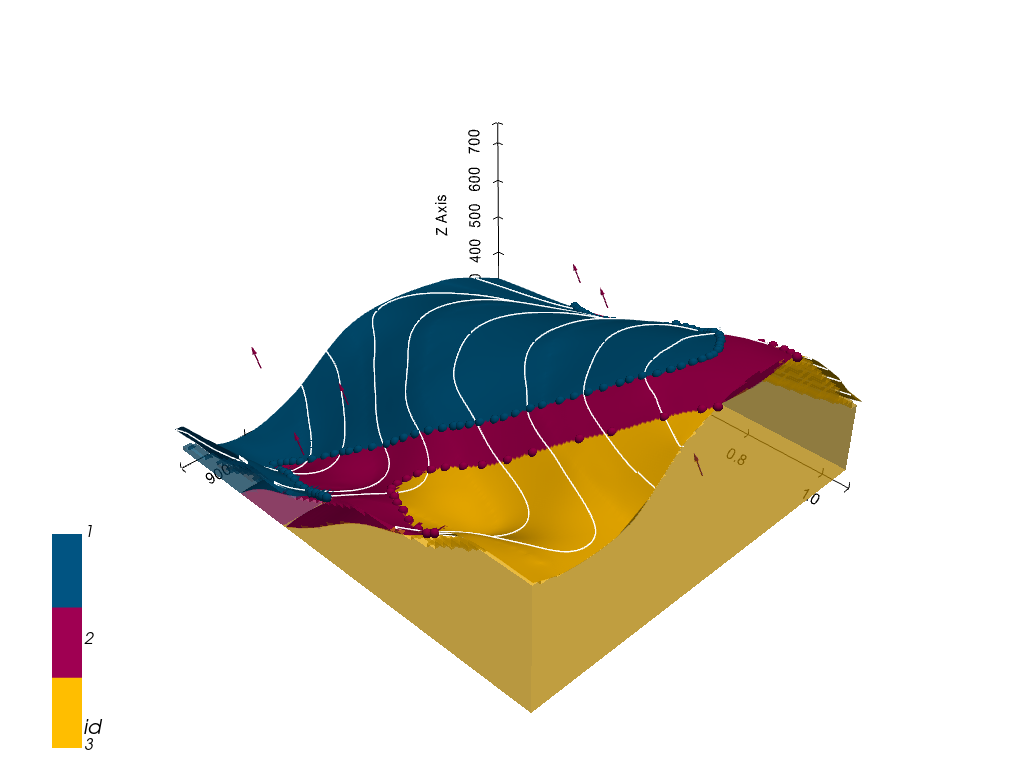

In [14]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=True,
                 plotter_type='basic', notebook=True, show_lith=True)

## Creating Depth Maps

When creating the depth maps, a dict containing the mesh, the depth values and the color of the surface within the GemPy Model are returned.

In [15]:
dict_sand1 = gg.visualization.create_depth_maps_from_gempy(geo_model=geo_model,
                                                           surfaces='Sand1')

dict_sand1

{'Sand1': [PolyData (0x17c28731ca0)
    N Cells:	4174
    N Points:	2303
    X Bounds:	9.720e+00, 9.623e+02
    Y Bounds:	1.881e+02, 9.491e+02
    Z Bounds:	3.050e+02, 7.250e+02
    N Arrays:	0,
  array([305.        , 305.        , 314.39133763, ..., 495.        ,
         495.        , 494.12916183]),
  '#015482']}

### Plotting Depth Maps

The depth maps can easily be plotted with PyVista.

In [18]:
dict_all = gg.visualization.create_depth_maps_from_gempy(geo_model=geo_model,
                                                         surfaces=['Sand1', 'Ton'])

dict_all

{'Sand1': [PolyData (0x17c28887100)
    N Cells:	4174
    N Points:	2303
    X Bounds:	9.720e+00, 9.623e+02
    Y Bounds:	1.881e+02, 9.491e+02
    Z Bounds:	3.050e+02, 7.250e+02
    N Arrays:	0,
  array([305.        , 305.        , 314.39133763, ..., 495.        ,
         495.        , 494.12916183]),
  '#015482'],
 'Ton': [PolyData (0x17c27ff8160)
    N Cells:	5111
    N Points:	2739
    X Bounds:	9.720e+00, 9.623e+02
    Y Bounds:	3.578e+02, 1.058e+03
    Z Bounds:	3.050e+02, 7.265e+02
    N Arrays:	0,
  array([305.        , 305.        , 314.91398156, ..., 595.        ,
         593.61738205, 595.        ]),
  '#9f0052']}

This data can be accessed as before to display both surfaces.

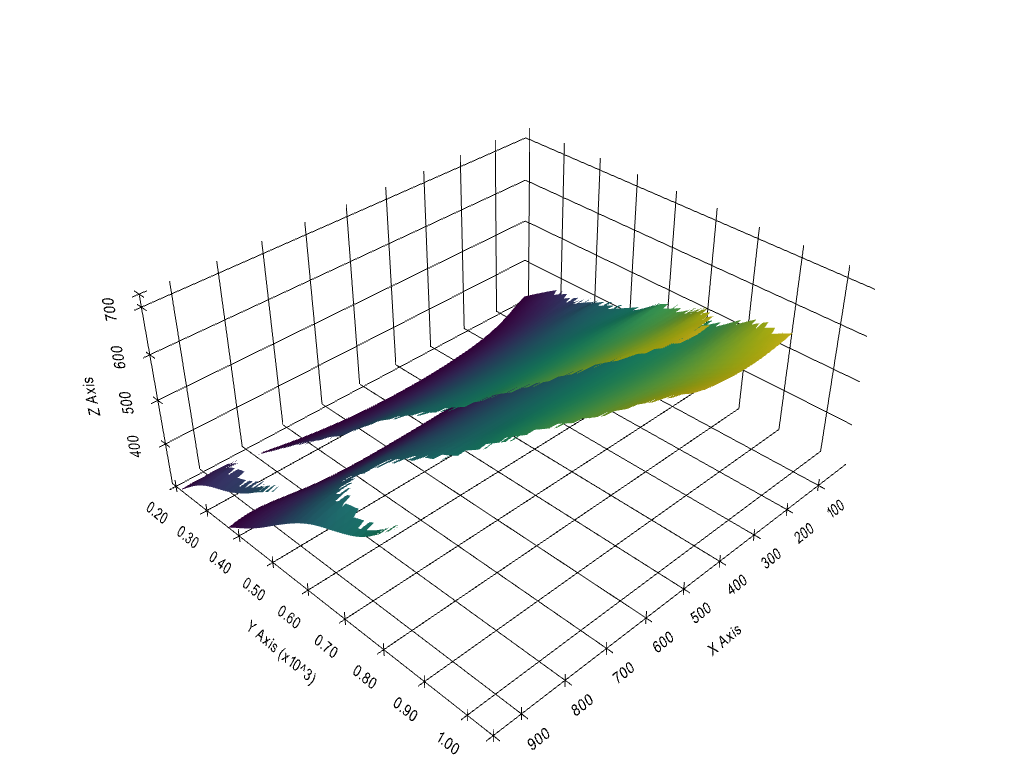

In [19]:
import pyvista as pv

p = pv.Plotter(notebook=True)

p.add_mesh(dict_all['Sand1'][0], scalars='Depth [m]')
p.add_mesh(dict_all['Ton'][0], scalars='Depth [m]')

p.set_background('white')
p.show_grid(color='black')
p.show()

## Creating Thickness Map

The thickness map can be calculated using ``create_thickness_maps(..)``. The thickness is calculated using normal vectors of the bottom surface and intersecting them with the upper surface. In places where no upper surface is available, the value is set to 0. 

In [23]:
thickness_map = gg.visualization.create_thickness_maps(top_surface=dict_all['Sand1'][0],
                                                       base_surface=dict_all['Ton'][0])
thickness_map

PolyData (0x17c341a14c0)
  N Cells:	5111
  N Points:	2739
  X Bounds:	9.720e+00, 9.623e+02
  Y Bounds:	3.578e+02, 1.058e+03
  Z Bounds:	3.050e+02, 7.265e+02
  N Arrays:	3

### Plotting the Thickness map

The thickness map can now be plotted using PyVista. The ``nan_opacity`` value is set to 0 so that ``nan`` values are not shown. The array ``Thickness [m]`` contains the thickness values and is plotted as ``scalars`` of the mesh. The thickness map is plotted at the location of the ``base_surface``.

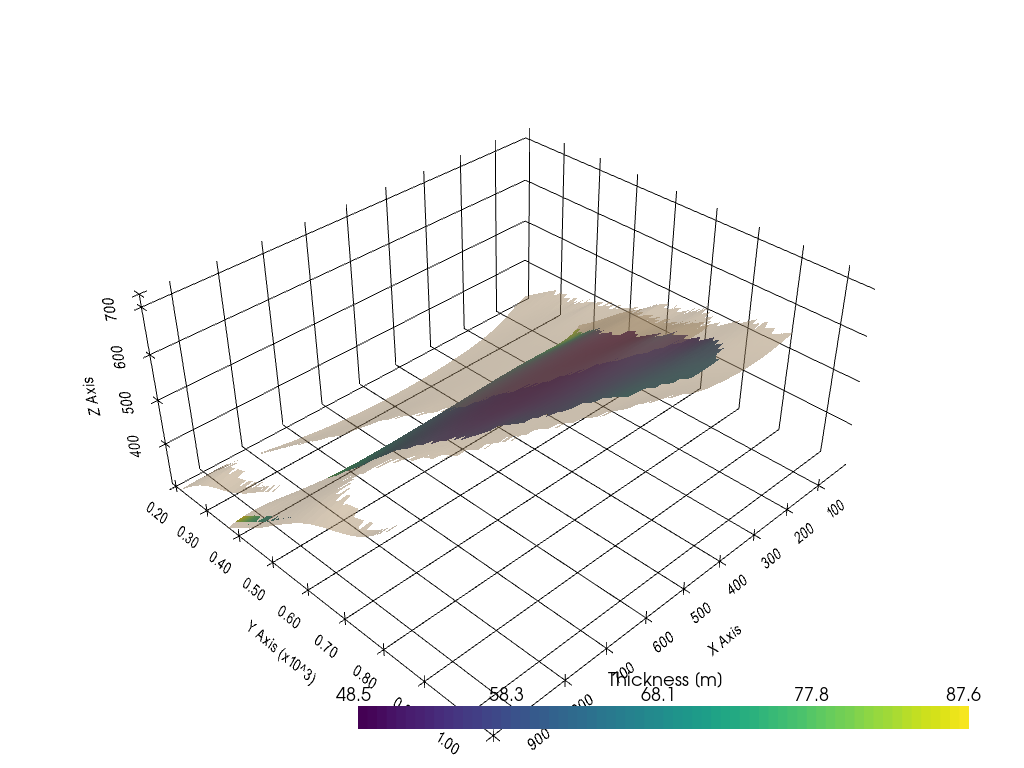

In [38]:
import pyvista as pv

p = pv.Plotter(notebook=True)

p.add_mesh(thickness_map, scalars= 'Thickness [m]', nan_opacity=0)
p.add_mesh(dict_all['Sand1'][0], color=True, opacity=0.5)
p.add_mesh(dict_all['Ton'][0], color=True, opacity=0.5)


p.set_background('white')
p.show_grid(color='black')
p.show()